In [6]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
import re
import os
from glob import glob
import pandas as pd
import numpy as np
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/duongcongthuyet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Load Model

8GB RAM : valhalla/distilbart-mnli-12-3
Google Colab: facebook/bart-large-mnli

In [7]:
model_name = "valhalla/distilbart-mnli-12-3"
device = 0 if torch.cuda.is_available() else 'cpu'

In [8]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier

In [9]:
theme_classifier = load_model(device)

Device set to use cpu


In [10]:
theme_lists = ["Hope","Despair","Trust","Isolation","Rebellion","Danger","Love","Guilt"]

In [11]:

theme_classifier(
    "A group of kids encounter strange events in Hawkins while searching for their lost friend.",
    theme_lists,
    multi_label = True
)

{'sequence': 'A group of kids encounter strange events in Hawkins while searching for their lost friend.',
 'labels': ['Danger',
  'Rebellion',
  'Despair',
  'Trust',
  'Guilt',
  'Hope',
  'Isolation',
  'Love'],
 'scores': [0.17511320114135742,
  0.008674344047904015,
  0.006497863680124283,
  0.004877186845988035,
  0.003746243892237544,
  0.0030237073078751564,
  0.00180991948582232,
  0.0005362313822843134]}

#Load Dataset

In [12]:
files = glob('../data/Subtitles/*.srt')

In [13]:
files[:5]

['../data/Subtitles/Stranger.Things.S04E03.NF.WEB-DL.HI.srt',
 '../data/Subtitles/Stranger.Things.S01E08.WEBRip.x264-TURBO.srt',
 '../data/Subtitles/Stranger.Things.S04E08.NF.WEB-DL.HI.srt',
 '../data/Subtitles/Stranger.Things.S03E06.WEBRip.x264-ION10-HI.srt',
 '../data/Subtitles/Stranger.Things.S03E02.WEBRip.x264-ION10-HI.srt']

In [14]:
with open(files[0], 'r') as f:
    text = f.readlines()
    
lines = [None]
current_captions = []
i = 0
while i < len(text):
    line = text[i].strip()
    if not line:
        i += 1
        continue
        
    if line.isdigit():
        i += 1
        if i < len(text) and ' --> ' in text[i]:
            i += 1
            caption_text = []
            while i < len(text) and text[i].strip():
                caption_text.append(text[i].strip())
                i += 1
            
            if caption_text:
                current_captions.append(caption_text[0] + " ")
                lines.append(list(current_captions))
    else:
        i += 1

lines[5]

['[faint rumbling] ',
 '[dishware rattling] ',
 '[ominous rumbling building] ',
 '[pots and pans clanging] ',
 '- [helicopter blades whirring] ']

In [15]:
" ".join(lines[10])

'[faint rumbling]  [dishware rattling]  [ominous rumbling building]  [pots and pans clanging]  - [helicopter blades whirring]  [dramatic music playing]  [woman grunts]  Sam.  [blades slowing]  [dramatic musical flourish] '

In [16]:
season = int(re.search(r'S(\d+)E(\d+)',files[0]).group(1))
episode = int(re.search(r'S(\d+)E(\d+)',files[0]).group(2))

In [17]:
def load_subtitles_dataset(dataset_path):
    subtitles_path = glob(os.path.join(dataset_path, '*.srt'))
    scripts = []
    episode_num = []
    episode_season = []

    for path in subtitles_path:
        # Đọc file
        with open(path, 'r', encoding='utf-8') as f:
            text = f.readlines()

        lines = []  # Không khởi tạo với None
        current_captions = []
        i = 0
        while i < len(text):
            line = text[i].strip()
            if not line:
                i += 1
                continue

            if line.isdigit():
                i += 1
                if i < len(text) and ' --> ' in text[i]:  # Dòng thời gian
                    i += 1
                    caption_text = []
                    while i < len(text) and text[i].strip():
                        caption_text.append(text[i].strip())
                        i += 1
                    
                    if caption_text:
                        lines.extend(caption_text)  # Thêm trực tiếp vào `lines`
            else:
                i += 1

        script = " ".join(lines)  # Ghép nội dung lại

        match = re.search(r'S(\d+)E(\d+)', path)
        if match:
            season = int(match.group(1))
            episode = int(match.group(2))
            scripts.append(script)
            episode_num.append(episode)
            episode_season.append(season)

    df = pd.DataFrame.from_dict({"season": episode_season, "episode": episode_num, "script": scripts})
    return df


In [18]:
dataset_path = '../data/Subtitles'
df = load_subtitles_dataset(dataset_path)
df = df.sort_values(by=['season', 'episode'], ascending=[True, True])


In [19]:
df.head(5)

,season,episode,script
19,1,1,(ALARM BLARING) (PANTING) (ELEVATOR DESCENDING...
5,1,2,(THUNDER RUMBLING) (BREATHING HEAVILY) (MIKE) ...
26,1,3,Hello? Nancy? Nancy! (SHOUTS) Hello? - (GROWLI...
13,1,4,"POWELL: This the wall she was talking about, C..."
27,1,5,[woman] Thanks. [indistinct chatter] [breathin...


Run Model

In [20]:
script = df.iloc[0]['script']

In [21]:
# Fix the set_tokenizer issue
import nltk
download_dir = '/Users/duongcongthuyet/Downloads/workspace/AI/.venv/nltk_data'
nltk.download('punkt_tab', download_dir=download_dir)
nltk.data.path.append(download_dir)  # Add this path to NLTK’s search list

[nltk_data] Downloading package punkt_tab to /Users/duongcongthuyet/Do
[nltk_data]     wnloads/workspace/AI/.venv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
script_sentences = sent_tokenize(script)
script_sentences[:5]

['(ALARM BLARING) (PANTING) (ELEVATOR DESCENDING) (ELEVATOR DINGS) (BREATHING HEAVILY) (LOW GROWLING) (SCREAMING) MIKE: Something is coming.',
 'Something hungry for blood.',
 'A shadow grows on the wall behind you, swallowing you in darkness.',
 '- It is almost here.',
 '- What is it?']

In [23]:
#Batch sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index: index + sentence_batch_size])
    script_batches.append(sent)

script_batches[:2]

["(ALARM BLARING) (PANTING) (ELEVATOR DESCENDING) (ELEVATOR DINGS) (BREATHING HEAVILY) (LOW GROWLING) (SCREAMING) MIKE: Something is coming. Something hungry for blood. A shadow grows on the wall behind you, swallowing you in darkness. - It is almost here. - What is it? What if it's the Demogorgon? Oh, Jesus, we're so screwed if it's the Demogorgon. It's not the Demogorgon. An army of troglodytes charge into the chamber! - Troglodytes? - Told ya. (CHUCKLING) - (SNORTS) - (ALL CHUCKLING) (SOFTLY) Wait a minute. Did you hear that? That... that sound? Boom... boom... - (YELLS) Boom! - (SLAMS TABLE) That didn't come from the troglodytes. No, that... That came from something else. - The Demogorgon! - (ALL GROANING) - We're in deep shit. - Will, your action!",
 "- I don't know! - Fireball him! I'd have to roll a 13 or higher! Too risky. Cast a protection spell. - Don't be a pussy. Fireball him! - Cast Protection. The Demogorgon is tired of your silly human bickering! It stomps towards you. -

In [24]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_lists,
    multi_label = True
)
theme_output

[{'sequence': "(ALARM BLARING) (PANTING) (ELEVATOR DESCENDING) (ELEVATOR DINGS) (BREATHING HEAVILY) (LOW GROWLING) (SCREAMING) MIKE: Something is coming. Something hungry for blood. A shadow grows on the wall behind you, swallowing you in darkness. - It is almost here. - What is it? What if it's the Demogorgon? Oh, Jesus, we're so screwed if it's the Demogorgon. It's not the Demogorgon. An army of troglodytes charge into the chamber! - Troglodytes? - Told ya. (CHUCKLING) - (SNORTS) - (ALL CHUCKLING) (SOFTLY) Wait a minute. Did you hear that? That... that sound? Boom... boom... - (YELLS) Boom! - (SLAMS TABLE) That didn't come from the troglodytes. No, that... That came from something else. - The Demogorgon! - (ALL GROANING) - We're in deep shit. - Will, your action!",
  'labels': ['Isolation',
   'Danger',
   'Trust',
   'Rebellion',
   'Guilt',
   'Despair',
   'Hope',
   'Love'],
  'scores': [0.3522258400917053,
   0.3437404930591583,
   0.32612529397010803,
   0.3163623809814453,
   

In [25]:
# Wrangle Output
themes ={}
for output in theme_output:
    for label,score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)


In [26]:
themes = {key : np.mean(np.array(value)) for key,value in themes.items()}
    

In [27]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
    #Batch sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index: index + sentence_batch_size])
        script_batches.append(sent)
    #Run model
    theme_output = theme_classifier(
        script_batches,
        theme_lists,
        multi_label = True
    )
    # Wrangle Output
    themes ={}
    for output in theme_output:
        for label,score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
    themes = {key : np.mean(np.array(value)) for key,value in themes.items()}
    return themes

In [28]:
df = df.head(2)
df

,season,episode,script
19,1,1,(ALARM BLARING) (PANTING) (ELEVATOR DESCENDING...
5,1,2,(THUNDER RUMBLING) (BREATHING HEAVILY) (MIKE) ...


In [29]:
output_theme = df['script'].apply(get_themes_inference)
output_theme

19    {'Isolation': 0.5155695422020342, 'Danger': 0....
5     {'Guilt': 0.4144470893539662, 'Danger': 0.3956...
Name: script, dtype: object

In [30]:
theme_df = pd.DataFrame(output_theme.tolist())
theme_df

,Isolation,Danger,Trust,Rebellion,Guilt,Despair,Hope,Love
0,0.515570,0.519857,0.510538,0.488584,0.518608,0.421234,0.376865,0.340072
1,0.392064,0.395637,0.414887,0.376036,0.414447,0.309934,0.306824,0.286134


In [31]:
theme_df.index = df.index
df.loc[:, theme_df.columns] = theme_df
df

,season,episode,script,Isolation,Danger,Trust,Rebellion,Guilt,Despair,Hope,Love
19,1,1,(ALARM BLARING) (PANTING) (ELEVATOR DESCENDING...,0.515570,0.519857,0.510538,0.488584,0.518608,0.421234,0.376865,0.340072
5,1,2,(THUNDER RUMBLING) (BREATHING HEAVILY) (MIKE) ...,0.392064,0.395637,0.414887,0.376036,0.414447,0.309934,0.306824,0.286134


#Visualize output

In [32]:
theme_output = df.drop(['season', 'episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,Isolation,0.907634
1,Danger,0.915494
2,Trust,0.925425
3,Rebellion,0.864620
4,Guilt,0.933055
5,Despair,0.731168
6,Hope,0.683690
7,Love,0.626206


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

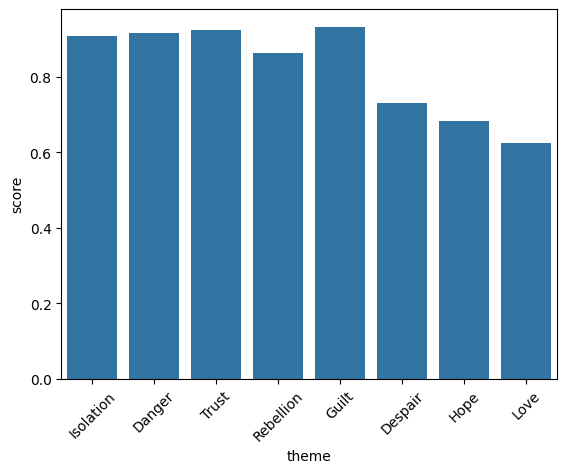

In [35]:
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()